/opt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in arccos


<IPython.core.display.Javascript object>


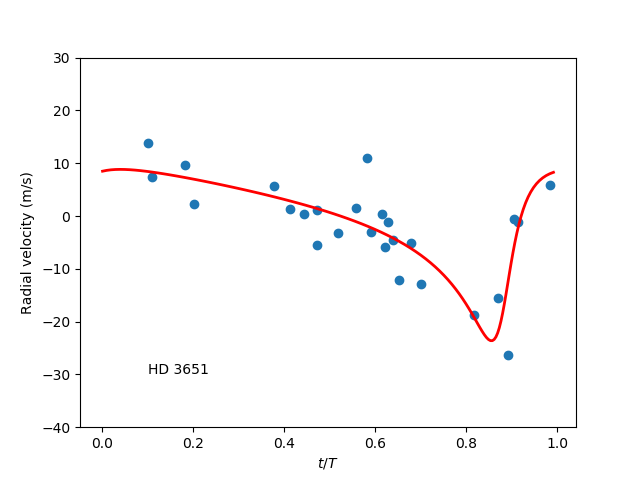

((-40, 30), None)

In [28]:
#
# Program 4.4: Radial velocity data modeling (rvfit.ipynb)
# J Wang, Computational modeling and visualization with Python
#

import numpy as np                      # get numpy
import matplotlib.pyplot as plt         # get plot functions
from scipy.optimize import leastsq      # least square fit
%matplotlib notebook

def rv(V, e, omega, C, theta):      # radial velocity
    return -V*(np.cos(omega + theta) - e*np.cos(omega)) + C

def nearest(a, b):    # find indices of neareast differences
    diff = np.subtract.outer(a, b)      # find diff: a=[], b=[] or scalar 
    return np.argmin(np.abs(diff), 0)   # nearest index

def time_theta(e, tshift, fit=True):    # calc time and theta
    psi = np.linspace(0., 2*np.pi, 101) # psi grid
    t = (psi+e*np.sin(psi))/(2*np.pi) + tshift      # Kepler eqn
    over, under = t>1.0, t<=1.0         # truth arrays
    t = np.concatenate((t[over]-1, t[under]))       # wrap around 
    theta = np.arccos((e+np.cos(psi))/(1+e*np.cos(psi))) # calc theta
    theta[psi>np.pi] = 2*np.pi-theta[psi>np.pi]          # remap to [0,2*pi]
    theta = np.concatenate((theta[over], theta[under]))  # wrap around
    idx = nearest(t, time)              # index of data points
    return (t[idx], theta[idx]) if fit else (t, theta)

def error(p, v, tshift):        # error function for leastsq
    t, theta = time_theta(p[e], tshift)
    return  v - rv(p[V], p[e], p[omega], p[C], theta)

T, tshift = 62.23, 0.38         # T=period (day), expt. with time shift 
time, vel, err = [], [], []
with open('../datafiles/rvdata.txt', 'r') as file:   # read HD 3651 dataset 
    for line in file:
        if line.strip() and line.strip()[0]!='#':   # not blank/comment
            t, v = eval(line)       # comma separated fields
            time.append(t), vel.append(v)
time, vel = np.array(time)/T, np.array(vel)         # scaled time

p = [10., 0.5, 1., 1.]      # initial guess: [V, e, omega, C]
V, e, omega, C = range(4)   # para labels [0-3] for easy ref
p, flag = leastsq(error, p, args=(vel, tshift))     # Go fit 

t, theta = time_theta(p[e], tshift, 0)      # calc fitted results
vfit = rv(p[V], p[e], p[omega], p[C], theta)

plt.figure()
plt.plot(time, vel, 'o')       # data and fit
plt.plot(t, vfit, lw=2, color='red')
plt.xlabel('$t/T$'), plt.ylabel('Radial velocity (m/s)')
plt.text(0.10, -30, 'HD 3651')      
plt.ylim(-40, 30),  plt.show()              # set ylim 